In [19]:
from lenskit import batch, topn, util
from lenskit.algorithms import Recommender, als
import pandas as pd
import time
import numpy as np

In [14]:
def sub_sample(train,test,sample_size):
    
    user_ids = pd.DataFrame(train.user_id.unique())
    
    training_ids = user_ids.sample(frac=sample_size, random_state=10)
    
    training_ids = training_ids.rename(columns={0: "user_id"})
    
    final_train = training_ids.merge(train, on = "user_id")
    
    final_test = training_ids.merge(test, on = "user_id")
    
    return final_train, final_test

In [15]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    recs = batch.recommend(fittable, users, 500)
    recs['Algorithm'] = aname
    return recs

In [16]:
train = pd.read_parquet('Train_Subsample.parquet')
test = pd.read_parquet('Test_Subsample.parquet')
test = test.dropna()

In [52]:
# Best Features from cluster ALS model
feat, max_iter, reg, weight = 125, 20, 10, 100

als_model = als.ImplicitMF(features=feat, iterations=max_iter, reg=reg, weight=weight)

sampleSize = [.1*i for i in range(1,10)]
prec = []
times = []

for s in sampleSize:
    
    df_train, df_test = sub_sample(train,test,s)

    df_train = df_train.rename(columns={'user_id':'user', 'track_id':'item', 'count':'rating'})

    df_test = df_test.rename(columns={'user_id':'user', 'track_id':'item', 'count':'rating'})

    start_time = time.time()

    all_recs = []
    test_data = []

    test_data.append(df_test)

    all_recs.append(eval('ALS', als_model, df_train, df_test))

    all_recs = pd.concat(all_recs, ignore_index=True)           
    test_data = pd.concat(test_data, ignore_index=True)

    rla = topn.RecListAnalysis()
    rla.add_metric(topn.precision)
    results = rla.compute(all_recs, test_data)

    precision = results.precision.mean()
    prec.append(precision)

    end_time = time.time()
    elapsed = end_time - start_time
    times.append(elapsed)

Parameters:
    features:     125
    regularizer:  10
    weight:       100
    iterations:   20


In [50]:
import matplotlib.pyplot as plt

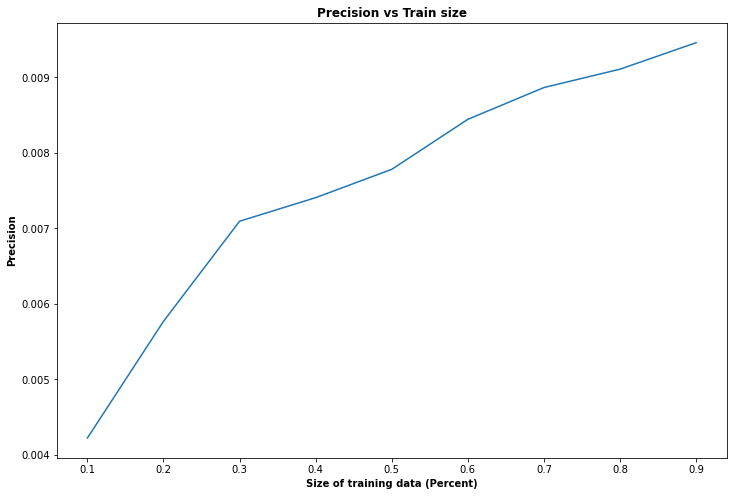

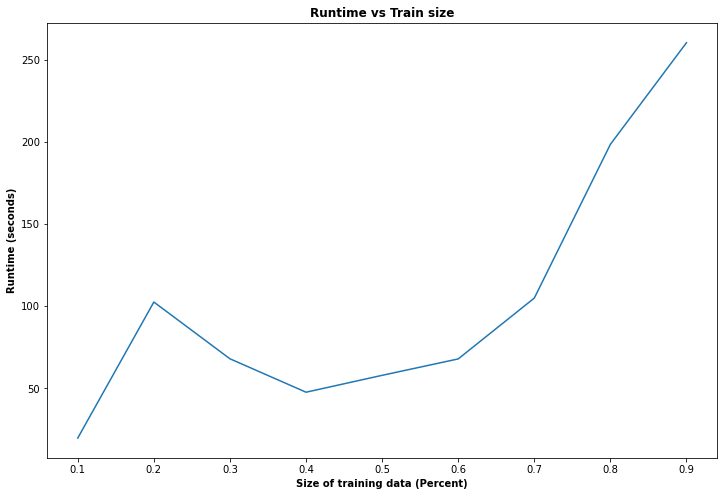

In [51]:
plt.figure(figsize=(12,8))
plt.plot(sampleSize, prec)
plt.xlabel("Size of training data (Percent)", fontweight="semibold")
plt.ylabel("Precision", fontweight="semibold")
plt.title("Precision vs Train size", fontweight="semibold")
plt.show()


plt.figure(figsize=(12,8))
plt.plot(sampleSize, times)
plt.xlabel("Size of training data (Percent)", fontweight="semibold")
plt.ylabel("Runtime (seconds)", fontweight="semibold")
plt.title("Runtime vs Train size", fontweight="semibold")
plt.show()